In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install marketing_attribution_models
from marketing_attribution_models import MAM


In [ ]:
from collections import defaultdict

In [ ]:
from google.colab import auth
auth.authenticate_user()

project="attribution-303016"
sql_query="SELECT * FROM `attribution-303016.Test2.testga2`"

df = pd.io.gbq.read_gbq(sql_query,project_id=project,dialect='standard')

In [ ]:
print (df)
df.sample(5)

                           cookie  ...         channel
0       0007iiAiFh3ifoo9Ehn3ABB0F  ...        Facebook
1       0007iiAiFh3ifoo9Ehn3ABB0F  ...        Facebook
2       0007o0nfoh9o79DDfD7DAiEnE  ...        Facebook
3       000BA9hECi3BiBkAifAA7ifA7  ...        Facebook
4       000C9f9DnCfoDF03BnfFAEFFC  ...        Facebook
...                           ...  ...             ...
586732  n97D90h07n3nB9f9Ck9BDknDD  ...  Online Display
586733  nhnik9CEBiDfBfDFE0Dnnh9f9  ...  Online Display
586734  noC3kDBA0DBE7EEh9nk9kh3AC  ...  Online Display
586735  o0kFhB07E373k0DFoABE7hDkE  ...  Online Display
586736  o9FhhCfC0CBokfooEfDF7B3iF  ...  Online Display

[586737 rows x 6 columns]


cookie  ...         channel
362013  ioiEhnh7AoD9okFEn73ho0Dih  ...     Paid Search
96650   F73BCfBnhfBE0okffB3iFA0Bk  ...        Facebook
248572  0F0ChhkhhDo0hE3koA0DDnnkF  ...     Paid Search
552109  hofA3f0AE0nn37AECAFkiCi7k  ...  Online Display
499215  okkD7AiEF990AiAkCiBhof3fn  ...    Online Video

[5 rows x 6 columns]

In [ ]:
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [ ]:
df

cookie  ... visit_order
390289  ooooohAFofEnonEikhAi3fF9o  ...           1
390288  ooooiBh70D3k3BfAhDFfii9h7  ...           1
500183  ooooiBh70D3k3BfAhDFfii9h7  ...           2
569095  ooooEiB0CCoEf9fiiC90Dfhfk  ...           1
569096  ooooEiB0CCoEf9fiiC90Dfhfk  ...           2
...                           ...  ...         ...
243402  0000nACkD9nFkBBDECD3ki00E  ...           6
170440  00000FkCnDfDDf0iC97iC703B  ...           1
500184  00000FkCnDfDDf0iC97iC703B  ...           2
500185  00000FkCnDfDDf0iC97iC703B  ...           3
500186  00000FkCnDfDDf0iC97iC703B  ...           4

[586737 rows x 7 columns]

In [ ]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()
    
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

df_paths['path'] = np.where(df_paths['conversion'] == 0, ['Start, '] + df_paths['channel'].apply(', '.join) + [', Null'], ['Start, '] + df_paths['channel'].apply(', '.join) + [', Conversion'])
df_paths['path'] = df_paths['path'].str.split(', ')

df_paths = df_paths[['cookie', 'path']]

In [ ]:
print(df_paths)

                           cookie                                      path
0       00000FkCnDfDDf0iC97iC703B  [Start, Instagram, Online Display, Null]
1       0000nACkD9nFkBBDECD3ki00E                [Start, Paid Search, Null]
2       0003EfE37E93D0BC03iBhBBhF                [Start, Paid Search, Null]
3       00073CFE3FoFCn70fBhB3kfon                  [Start, Instagram, Null]
4       00079hhBkDF3k3kDkiFi9EFAD                [Start, Paid Search, Null]
...                           ...                                       ...
240103  ooooE0hkAFBkED90ChDDiBFAf             [Start, Online Display, Null]
240104  ooooEBE0o0D97ACAAAnDoi3F0             [Start, Online Display, Null]
240105  ooooEiB0CCoEf9fiiC90Dfhfk             [Start, Online Display, Null]
240106  ooooiBh70D3k3BfAhDFfii9h7  [Start, Paid Search, Online Video, Null]
240107  ooooohAFofEnonEikhAi3fF9o                [Start, Paid Search, Null]

[240108 rows x 2 columns]


In [ ]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)
print(total_conversions)

17639


In [ ]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)


In [ ]:
trans_states

{'Conversion>Conversion': 0,
 'Conversion>Facebook': 0,
 'Conversion>Instagram': 0,
 'Conversion>Null': 0,
 'Conversion>Online Display': 0,
 'Conversion>Online Video': 0,
 'Conversion>Paid Search': 0,
 'Conversion>Start': 0,
 'Facebook>Conversion': 4688,
 'Facebook>Facebook': 0,
 'Facebook>Instagram': 15314,
 'Facebook>Null': 59264,
 'Facebook>Online Display': 2144,
 'Facebook>Online Video': 2253,
 'Facebook>Paid Search': 4462,
 'Facebook>Start': 0,
 'Instagram>Conversion': 2870,
 'Instagram>Facebook': 10759,
 'Instagram>Instagram': 0,
 'Instagram>Null': 31207,
 'Instagram>Online Display': 1166,
 'Instagram>Online Video': 1196,
 'Instagram>Paid Search': 2268,
 'Instagram>Start': 0,
 'Null>Conversion': 0,
 'Null>Facebook': 0,
 'Null>Instagram': 0,
 'Null>Null': 0,
 'Null>Online Display': 0,
 'Null>Online Video': 0,
 'Null>Paid Search': 0,
 'Null>Start': 0,
 'Online Display>Conversion': 2144,
 'Online Display>Facebook': 2302,
 'Online Display>Instagram': 1249,
 'Online Display>Null': 322

In [ ]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

trans_prob

defaultdict(dict,
            {'Facebook>Conversion': 0.053197163120567374,
             'Facebook>Instagram': 0.1737758865248227,
             'Facebook>Null': 0.6724992907801418,
             'Facebook>Online Display': 0.024329078014184397,
             'Facebook>Online Video': 0.02556595744680851,
             'Facebook>Paid Search': 0.050632624113475175,
             'Instagram>Conversion': 0.05801964986051025,
             'Instagram>Facebook': 0.21750293130635184,
             'Instagram>Null': 0.6308777746330813,
             'Instagram>Online Display': 0.02357174624994946,
             'Instagram>Online Video': 0.024178223426191726,
             'Instagram>Paid Search': 0.04584967452391542,
             'Online Display>Conversion': 0.05032391324758239,
             'Online Display>Facebook': 0.054032485212656085,
             'Online Display>Instagram': 0.02931649610365224,
             'Online Display>Null': 0.7566425687728852,
             'Online Display>Online Video': 0.017

In [ ]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [ ]:
trans_matrix

Null  Facebook  ...  Paid Search  Instagram
Null            1.000000  0.000000  ...     0.000000   0.000000
Facebook        0.672499  0.000000  ...     0.050633   0.173776
Conversion      0.000000  0.000000  ...     0.000000   0.000000
Online Video    0.763781  0.059274  ...     0.047947   0.031932
Start           0.000000  0.278666  ...     0.317399   0.118938
Online Display  0.756643  0.054032  ...     0.092386   0.029316
Paid Search     0.770779  0.064453  ...     0.000000   0.034185
Instagram       0.630878  0.217503  ...     0.045850   0.000000

[8 rows x 8 columns]

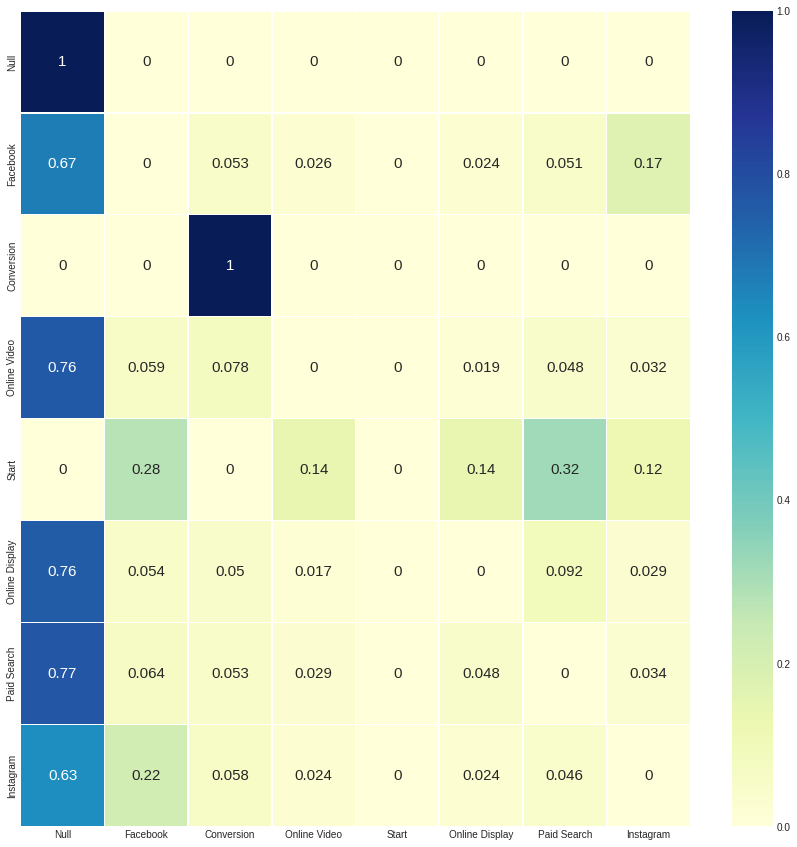

In [ ]:
ax, fig = plt.subplots(figsize=(15,15),)

sns.heatmap(trans_matrix.round(3), cmap="YlGnBu", annot=True, linewidths=.5, annot_kws={"size": 15})


In [ ]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [ ]:
removal_effects_dict

{'Facebook': 0.3548979540248247,
 'Instagram': 0.2172244970062326,
 'Online Display': 0.15435438116482636,
 'Online Video': 0.206910464866496,
 'Paid Search': 0.33110421365448617}

In [ ]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [ ]:
attributions

{'Facebook': 0.28066456043158877,
 'Instagram': 0.17178802322135295,
 'Online Display': 0.12206834119219966,
 'Online Video': 0.1636313594143422,
 'Paid Search': 0.2618477157405165}

In [ ]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [ ]:
attributions

{'Facebook': 0.28066456043158866,
 'Instagram': 0.17178802322135295,
 'Online Display': 0.12206834119219966,
 'Online Video': 0.1636313594143422,
 'Paid Search': 0.26184771574051663}

# D6 

**Baisert auf https://github.com/DP6/Marketing-Attribution-Models**